In [1]:
import pandas
import os
import string
import itertools
import pickle
from biotite.sequence.phylo import upgma
from matplotlib import pyplot
from io import StringIO
from Bio import Phylo
from ete3 import Tree

In [2]:
data_path = "../../data"

In [3]:
types_map = dict(P="with Protein", N="with Nucleotides")

In [4]:
df = pandas.read_csv(f"{data_path}/final_cluster.csv")

In [5]:
df.describe()

,Right,Total
count,60.0,60.0
mean,14.0,14.0
std,0.0,0.0
min,14.0,14.0
25%,14.0,14.0
50%,14.0,14.0
75%,14.0,14.0
max,14.0,14.0


In [6]:
df.sort_values(by="Right").head(30)

,Type,Algorithm,Name,Family,Right,Total
0,P,Resized Structural Similarity Index Measure,Mandrillus_leucophaeus_ENSMLEP00000005381_Mleu...,orthologs_hemoglobin_beta,14,14
32,N,Resized Structural Similarity Index Measure,Pan_paniscus_ENSPPAP00000004625_Ppan.png,orthologs_hemoglobin_beta,14,14
33,N,Resized Structural Similarity Index Measure,Prolemur_simus_ENSPSMP00000000465_Psim.png,orthologs_hemoglobin_beta,14,14
34,N,Resized Structural Similarity Index Measure,Nomascus_leucogenys_ENSNLEP00000021062_Nleu.png,orthologs_hemoglobin_beta,14,14
35,N,Resized Structural Similarity Index Measure,Cebus_capucinus_ENSCCAP00000028244_Ccap.png,orthologs_hemoglobin_beta,14,14
36,N,Resized Structural Similarity Index Measure,Aotus_nancymaae_ENSANAP00000000486_Anan.png,orthologs_hemoglobin_beta,14,14
37,N,Resized Structural Similarity Index Measure,Rhinopithecus_bieti_ENSRBIP00000023384_Rbie.png,orthologs_hemoglobin_beta,14,14
38,N,Resized Structural Similarity Index Measure,Carlito_syrichta_ENSTSYP00000007411_Csyr.png,orthologs_hemoglobin_beta,14,14
39,N,Resized Structural Similarity Index Measure,Gorilla_gorilla_ENSGGOP00000022371_Ggor.png,orthologs_hemoglobin_beta,14,14
40,N,Resized Structural Similarity Index Measure,Chlorocebus_sabaeus_ENSCSAP00000000618_Csab.png,orthologs_hemoglobin_beta,14,14


In [7]:
df.groupby(["Type", "Algorithm"]).apply(lambda x: x[x["Right"] == x["Total"]].Name.size / x.Name.size)

Type  Algorithm                                  
N     Resized Structural Similarity Index Measure    1.0
P     Resized Structural Similarity Index Measure    1.0
dtype: float64

In [8]:
def color_clade(clade):
    green_pallete = [
        "darkolivegreen",
        "turquoise",
        "forestgreen",
        "green",
        "darkcyan",
        "teal",
        "mediumaquamarine",
        "seagreen",
        "limegreen",
        "mediumseagreen",
        "mediumspringgreen"]
    clade_colors = {
        "androglobin": "red",
        "cytoglobin": "orange",
        "neuroglobin": "blue",
        "myoglobin": "brown",
        "hemoglobin": "purple",
        "indelible": green_pallete
    }
    for name, color in clade_colors.items():
            if name in clade:
                return color if type(color) == str else color[int(clade[-1])]



In [9]:
def show_tree(types, alg, numpy_all):
    tree = upgma(abs(1.0-numpy_all))
    fig, ax = pyplot.subplots(1, 1, figsize=(10, 20), layout="constrained")
    newick = tree.to_newick(labels=list(fixed_df_all.columns), include_distance=False)
    newick = tree.to_newick(labels=["_".join(i.replace("-", "_").split("_")[1:]) for i in list(fixed_df_all.columns)], include_distance=False)
    with open(f"{data_path}/blast/{types}/db_blast {alg}.nw", "w") as f:
        f.write(newick)
    t = Phylo.read(StringIO(newick), "newick")
    #     t.ladderize()
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{alg} {types_map[types]}")
    ax.axis('off')
    Phylo.draw(
        t,
        show_confidence=False,
        axes=ax,
        do_show=False,
        label_colors=color_clade,
        branch_labels=lambda clade: "" if not clade.name else "{:.2f}".format(
            clade.confidence) if clade.confidence else ""
    )
    pyplot.xlabel("")
    pyplot.ylabel("")
    pyplot.tight_layout()
    pyplot.show()

In [10]:
def calc_map(types, alg, fixed_df_all):
    by_homologues = {}
    only_homologues = {}
    for column in fixed_df_all.columns:
        name = column.split("_")[0] if len(column.split("_")) == 2 else column.split("_")[1]
        k = 40 if len(column.split("_")) == 2 else 14
        if name in by_homologues:
            by_homologues[name] += list(fixed_df_all[column].sort_values(ascending=False).index[:k])
            only_homologues[name] += [i.split("_")[0] if len(i.split("_")) == 2 else i.split("_")[1] for i in fixed_df_all[column].sort_values(ascending=False).index[:k]]
        else:
            by_homologues[name] = list(fixed_df_all[column].sort_values(ascending=False).index[:k])
            only_homologues[name] = [i.split("_")[0] if len(i.split("_")) == 2 else i.split("_")[1] for i in fixed_df_all[column].sort_values(ascending=False).index[:k]]

    #Precision, MAP
    print(f"--------{alg} {types_map[types]}--------")
    for h in only_homologues:
        print(h)
        print("Precision:", sum([i==h for i in only_homologues[h]])/len(only_homologues[h]))
        precision = [0]
        p_k = 0
        for i in only_homologues[h]:
            precision.append((i==h)+precision[-1])
        for k in range(1,len(precision)):
            p_k += precision[k]/k
        print("Mean Average Precision", p_k/len(only_homologues[h]))
        print("-------------------------------------------------")

--------Resized Structural Similarity Index Measure with Protein--------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------


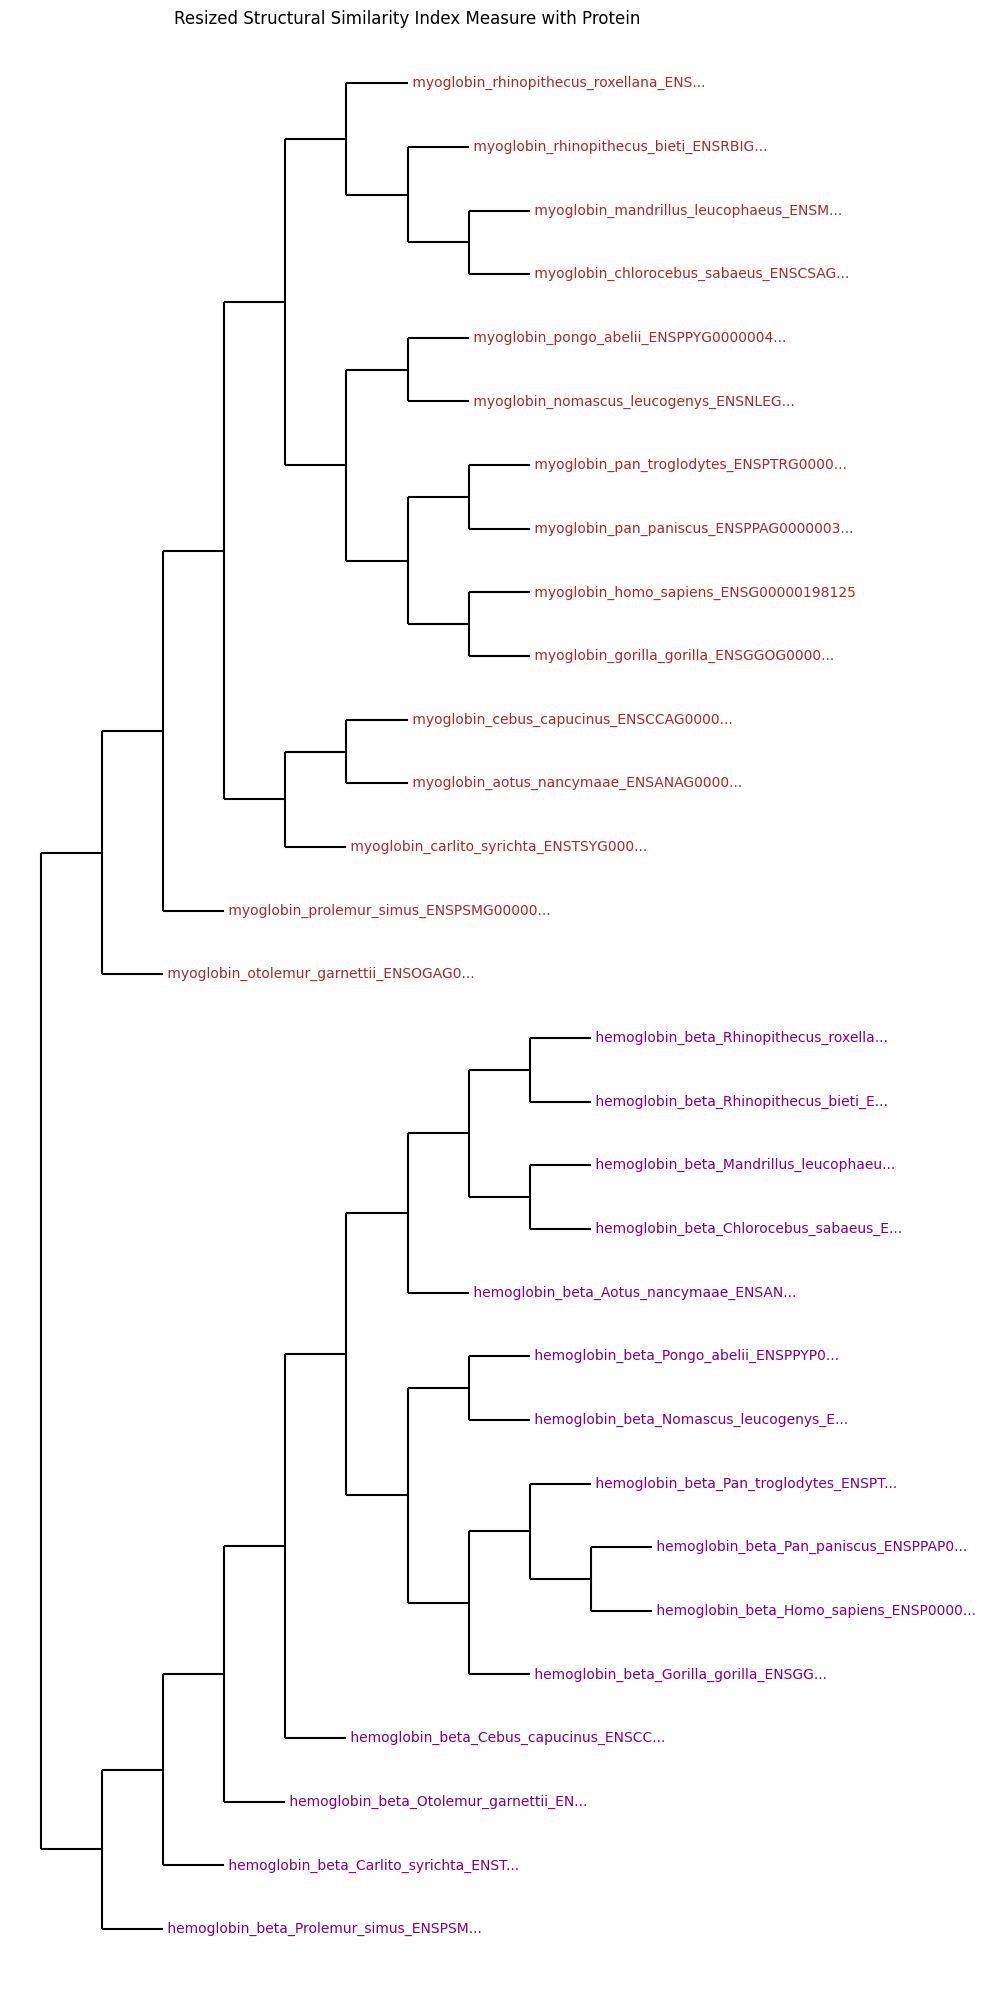

--------Resized Structural Similarity Index Measure with Nucleotides--------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------


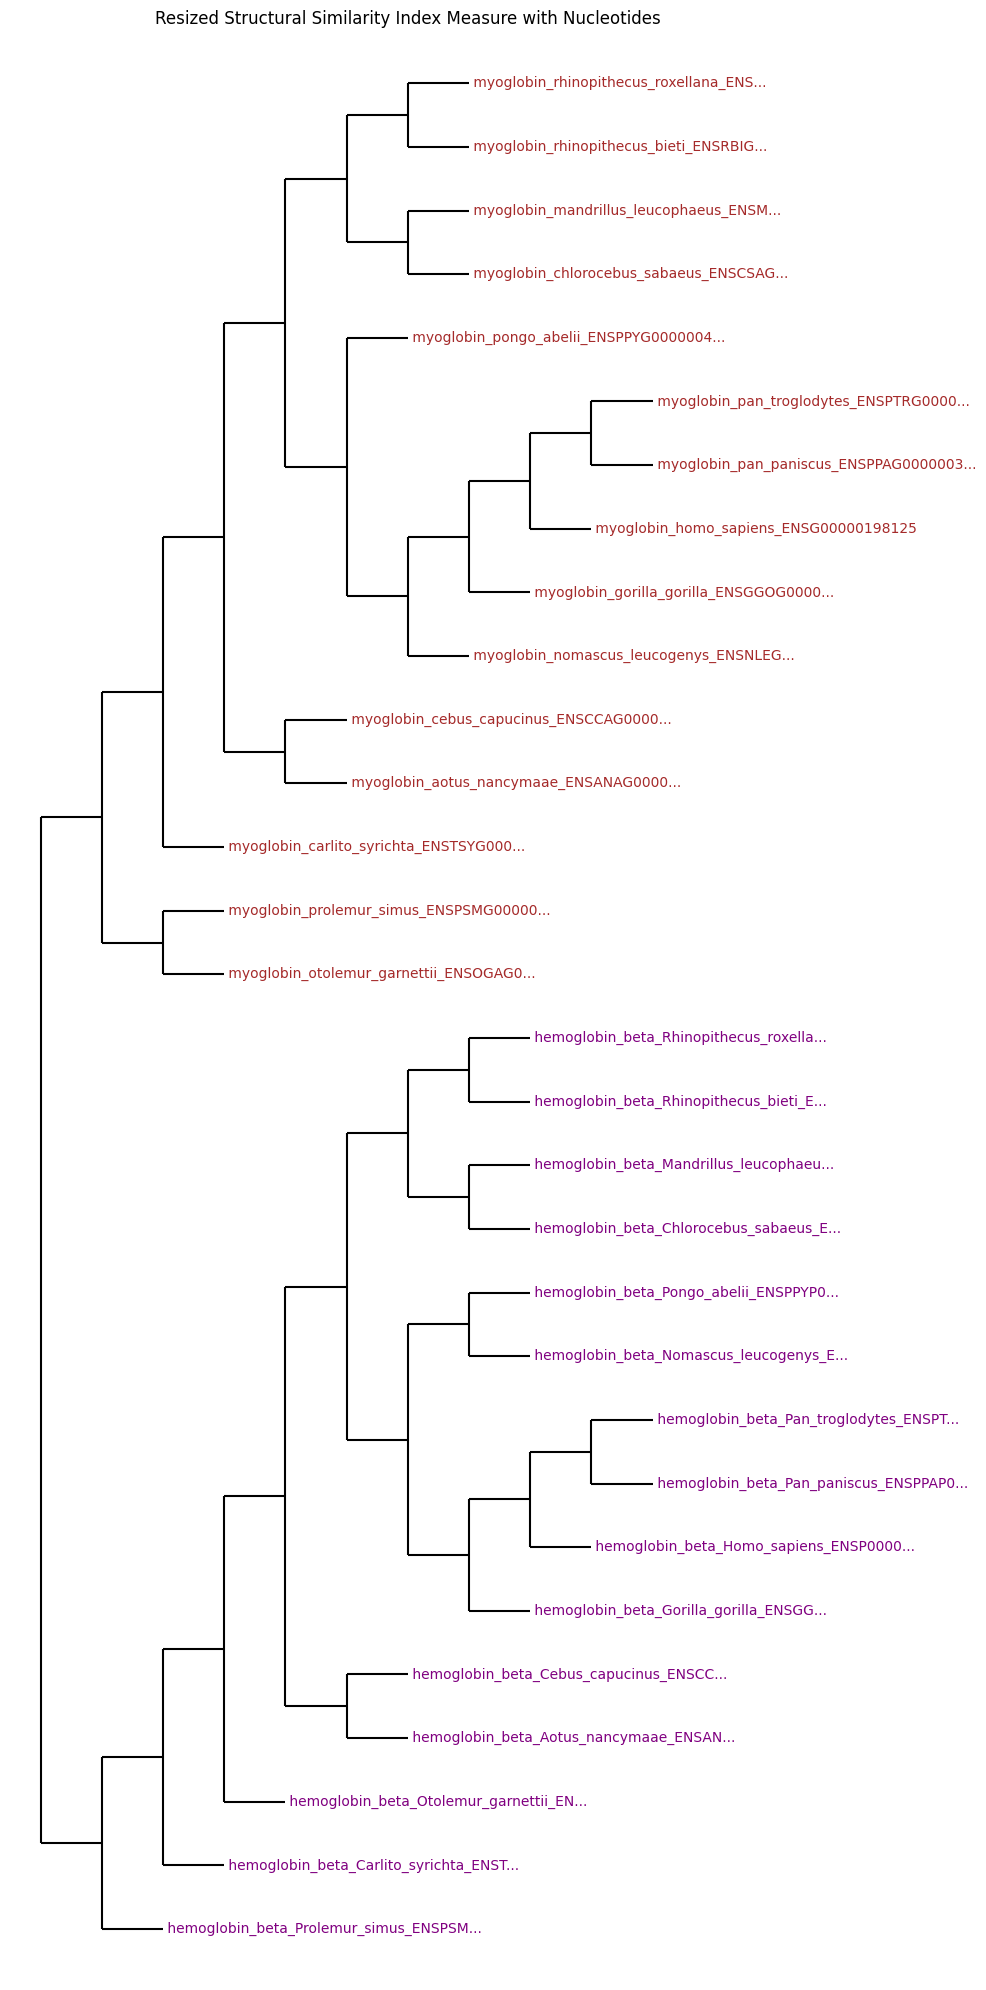

In [11]:
with open(f"{data_path}/cluster_sim.pkl", "rb") as f:
    sim_hash = pickle.load(f)
for types in sim_hash:
    for alg in sim_hash[types]:
        df_all = pandas.DataFrame.from_dict(sim_hash[types][alg])
        df_all.columns = [c.split("/")[-3].split(".")[0] +"_"+ c.split("/")[-1].split(".")[0] for c in df_all.columns]
        df_all.index = [c.split("/")[-3].split(".")[0] +"_"+ c.split("/")[-1].split(".")[0] for c in df_all.index]
        fixed_df_all = df_all.sort_index()[sorted(df_all.columns)]
        calc_map(types, alg, fixed_df_all)
        numpy_all = fixed_df_all.to_numpy(na_value=0)
        show_tree(types, alg, numpy_all)

In [12]:
for types in types_map.keys():
    dfs_control = {}
    control_dir = os.path.join(data_path, "blast", types)
    print(f"--------Results {types_map[types]}--------")
    for f in os.listdir(control_dir):
        if f.endswith(".csv"):
            name = f.split(".")[0]
            dfs_control[name] = pandas.read_csv(os.path.join(control_dir, f))
    for dataset, df_control in dfs_control.items():
        k=15 if "orthologs" in dataset else 40
        name = (dataset.replace("orthologs_", ""),) if "orthologs" in dataset else list(map("".join, itertools.product("ABCD", string.digits)))
        print(dataset)
        results = dfs_control[dataset].groupby("qseqid").head(k).groupby("qseqid").apply(
            lambda x: x["sseqid"].str.split("-", expand = True)[0].isin(name))
        print("Precision:", results.sum() / results.count())
        precision = [0]
        p_k = 0
        for i in results:
            precision.append(i+precision[-1])
        for k in range(1,len(precision)):
            p_k += precision[k]/k
        print("Mean Average Precision", p_k/results.count())
        display(results.groupby("qseqid").agg(right="sum", total="count"))
#         display(df_control.groupby("qseqid").head(k).pivot(index="qseqid", columns="sseqid", values="bitscore"))

--------Results with Protein--------
orthologs_cytoglobin
Precision: 1.0
Mean Average Precision 1.0


,right,total
qseqid,,
aotus_nancymaae_ENSANAG00000037374,15,15
carlito_syrichta_ENSTSYG00000029754,15,15
cebus_capucinus_ENSCCAG00000037088,15,15
chlorocebus_sabaeus_ENSCSAG00000005082,15,15
gorilla_gorilla_ENSGGOG00000001385,15,15
homo_sapiens_ENSG00000161544,15,15
mandrillus_leucophaeus_ENSMLEG00000043678,15,15
nomascus_leucogenys_ENSNLEG00000002476,15,15
otolemur_garnettii_ENSOGAG00000034659,15,15


orthologs_androglobin
Precision: 1.0
Mean Average Precision 1.0


,right,total
qseqid,,
aotus_nancymaae_ENSANAG00000025329,15,15
carlito_syrichta_ENSTSYG00000002644,15,15
cebus_capucinus_ENSCCAG00000032521,15,15
chlorocebus_sabaeus_ENSCSAG00000017175,15,15
gorilla_gorilla_ENSGGOG00000001069,15,15
homo_sapiens_ENSG00000118492,15,15
mandrillus_leucophaeus_ENSMLEG00000042349,15,15
nomascus_leucogenys_ENSNLEG00000015247,15,15
otolemur_garnettii_ENSOGAG00000024602,15,15


orthologs_hemoglobin_beta
Precision: 1.0
Mean Average Precision 1.0


,right,total
qseqid,,
Aotus_nancymaae_ENSANAP00000000486_Anan,15,15
Carlito_syrichta_ENSTSYP00000007411_Csyr,15,15
Cebus_capucinus_ENSCCAP00000028244_Ccap,15,15
Chlorocebus_sabaeus_ENSCSAP00000000618_Csab,15,15
Gorilla_gorilla_ENSGGOP00000022371_Ggor,15,15
Homo_sapiens_ENSP00000333994_Hsap,15,15
Mandrillus_leucophaeus_ENSMLEP00000005381_Mleu,15,15
Nomascus_leucogenys_ENSNLEP00000021062_Nleu,15,15
Otolemur_garnettii_ENSOGAP00000006779_Ogar,15,15


orthologs_myoglobin
Precision: 1.0
Mean Average Precision 1.0


,right,total
qseqid,,
aotus_nancymaae_ENSANAG00000020373,15,15
carlito_syrichta_ENSTSYG00000026219,15,15
cebus_capucinus_ENSCCAG00000031738,15,15
chlorocebus_sabaeus_ENSCSAG00000008174,15,15
gorilla_gorilla_ENSGGOG00000011478,15,15
homo_sapiens_ENSG00000198125,15,15
mandrillus_leucophaeus_ENSMLEG00000032335,15,15
nomascus_leucogenys_ENSNLEG00000014375,15,15
otolemur_garnettii_ENSOGAG00000005651,15,15


indelible
Precision: 0.604375
Mean Average Precision 0.605690257935267


,right,total
qseqid,,
A0,22,40
A1,20,40
A2,24,40
A3,26,40
A4,24,40
A5,16,40
A6,25,40
A7,24,40
A8,27,40


orthologs_neuroglobin
Precision: 1.0
Mean Average Precision 1.0


,right,total
qseqid,,
aotus_nancymaae_ENSANAG00000022420,15,15
carlito_syrichta_ENSTSYG00000026821,15,15
cebus_capucinus_ENSCCAG00000020944,15,15
chlorocebus_sabaeus_ENSCSAG00000011845,15,15
gorilla_gorilla_ENSGGOG00000006195,15,15
homo_sapiens_ENSG00000165553,15,15
mandrillus_leucophaeus_ENSMLEG00000035424,15,15
nomascus_leucogenys_ENSNLEG00000016682,15,15
otolemur_garnettii_ENSOGAG00000006194,15,15


--------Results with Nucleotides--------
orthologs_cytoglobin
Precision: 1.0
Mean Average Precision 1.0


,right,total
qseqid,,
aotus_nancymaae_ENSANAG00000037374,15,15
carlito_syrichta_ENSTSYG00000029754,15,15
cebus_capucinus_ENSCCAG00000037088,15,15
chlorocebus_sabaeus_ENSCSAG00000005082,15,15
gorilla_gorilla_ENSGGOG00000001385,15,15
homo_sapiens_ENSG00000161544,15,15
mandrillus_leucophaeus_ENSMLEG00000043678,15,15
nomascus_leucogenys_ENSNLEG00000002476,15,15
otolemur_garnettii_ENSOGAG00000034659,15,15


orthologs_androglobin
Precision: 1.0
Mean Average Precision 1.0


,right,total
qseqid,,
aotus_nancymaae_ENSANAG00000025329,15,15
carlito_syrichta_ENSTSYG00000002644,15,15
cebus_capucinus_ENSCCAG00000032521,15,15
chlorocebus_sabaeus_ENSCSAG00000017175,15,15
gorilla_gorilla_ENSGGOG00000001069,15,15
homo_sapiens_ENSG00000118492,15,15
mandrillus_leucophaeus_ENSMLEG00000042349,15,15
nomascus_leucogenys_ENSNLEG00000015247,15,15
otolemur_garnettii_ENSOGAG00000024602,15,15


orthologs_hemoglobin_beta
Precision: 1.0
Mean Average Precision 1.0


,right,total
qseqid,,
Aotus_nancymaae_ENSANAP00000000486_Anan,15,15
Carlito_syrichta_ENSTSYP00000007411_Csyr,15,15
Cebus_capucinus_ENSCCAP00000028244_Ccap,15,15
Chlorocebus_sabaeus_ENSCSAP00000000618_Csab,15,15
Gorilla_gorilla_ENSGGOP00000022371_Ggor,15,15
Homo_sapiens_ENSP00000333994_Hsap,15,15
Mandrillus_leucophaeus_ENSMLEP00000005381_Mleu,15,15
Nomascus_leucogenys_ENSNLEP00000021062_Nleu,15,15
Otolemur_garnettii_ENSOGAP00000006779_Ogar,15,15


orthologs_myoglobin
Precision: 1.0
Mean Average Precision 1.0


,right,total
qseqid,,
aotus_nancymaae_ENSANAG00000020373,15,15
carlito_syrichta_ENSTSYG00000026219,15,15
cebus_capucinus_ENSCCAG00000031738,15,15
chlorocebus_sabaeus_ENSCSAG00000008174,15,15
gorilla_gorilla_ENSGGOG00000011478,15,15
homo_sapiens_ENSG00000198125,15,15
mandrillus_leucophaeus_ENSMLEG00000032335,15,15
nomascus_leucogenys_ENSNLEG00000014375,15,15
otolemur_garnettii_ENSOGAG00000005651,15,15


indelible
Precision: 0.6575
Mean Average Precision 0.6632178984228819


,right,total
qseqid,,
A0,25,40
A1,26,40
A2,28,40
A3,28,40
A4,24,40
A5,26,40
A6,22,40
A7,26,40
A8,32,40


orthologs_neuroglobin
Precision: 1.0
Mean Average Precision 1.0


,right,total
qseqid,,
aotus_nancymaae_ENSANAG00000022420,15,15
carlito_syrichta_ENSTSYG00000026821,15,15
cebus_capucinus_ENSCCAG00000020944,15,15
chlorocebus_sabaeus_ENSCSAG00000011845,15,15
gorilla_gorilla_ENSGGOG00000006195,15,15
homo_sapiens_ENSG00000165553,15,15
mandrillus_leucophaeus_ENSMLEG00000035424,15,15
nomascus_leucogenys_ENSNLEG00000016682,15,15
otolemur_garnettii_ENSOGAG00000006194,15,15


In [13]:
for types in types_map.keys():
    print(f"--------Results {types_map[types]}--------")
    control_tree = Tree(f"{data_path}/blast/{types}/db_blast_guided.nw", format=1)
    control_phylo_tree = Tree(f"{data_path}/blast/{types}/db_blast_phylo.nw", format=1)
    result_dict = {"control_guided":[], "control_phylo": []}
    print(control_tree.compare(control_phylo_tree, unrooted=True)["norm_rf"])
    indexes = []
    for file in os.listdir(f"{data_path}/blast/{types}/"):
        if file.endswith(".nw") and file.startswith("db_blast "):
            alg = file.split("db_blast ")[1].split(".")[0]
            tree = Tree(f"{data_path}/blast/{types}/{file}", format=1)
            result = control_tree.compare(tree, unrooted=True)
            result_dict["control_guided"].append(result["norm_rf"])
            result = control_phylo_tree.compare(tree, unrooted=True)
            result_dict["control_phylo"].append(result["norm_rf"])
            indexes.append(alg)
    display(pandas.DataFrame(result_dict, index=indexes))

--------Results with Protein--------
0.21428571428571427


,control_guided,control_phylo
MultiScale Structural Similarity Index Measure Compat,0.652778,0.694444
Resized Structural Similarity Index Measure,0.296296,0.222222
Structural Similarity Index Measure Compat,0.666667,0.666667
MultiScale Structural Similarity Index Measure,0.596491,0.631579
Universal Quality Index,0.684211,0.701754
Universal Quality Index Compat,0.750000,0.763889
Structural Similarity Index Measure,0.614035,0.596491


--------Results with Nucleotides--------
0.15178571428571427


,control_guided,control_phylo
MultiScale Structural Similarity Index Measure Compat,0.458333,0.458333
Resized Structural Similarity Index Measure,0.185185,0.111111
Structural Similarity Index Measure Compat,0.444444,0.444444
MultiScale Structural Similarity Index Measure,0.350877,0.350877
Universal Quality Index,0.421053,0.421053
Universal Quality Index Compat,0.541667,0.541667
Structural Similarity Index Measure,0.333333,0.333333


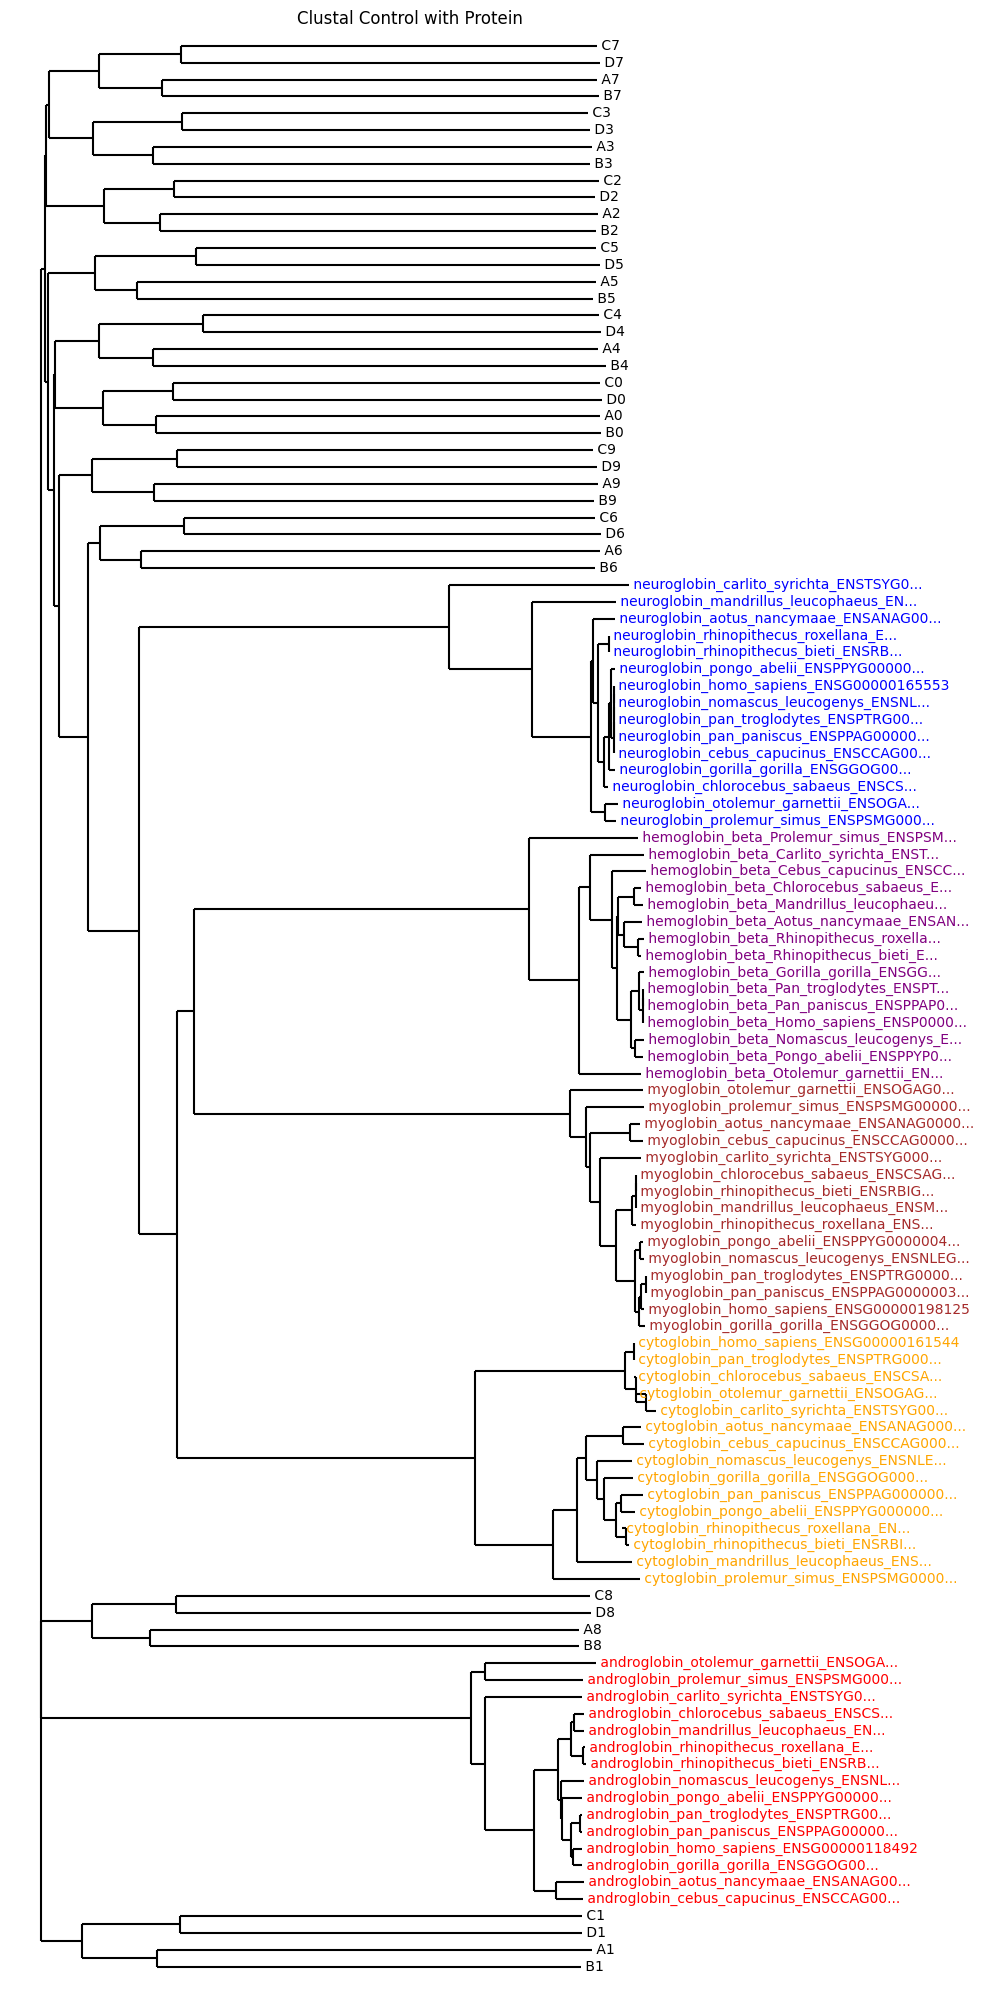

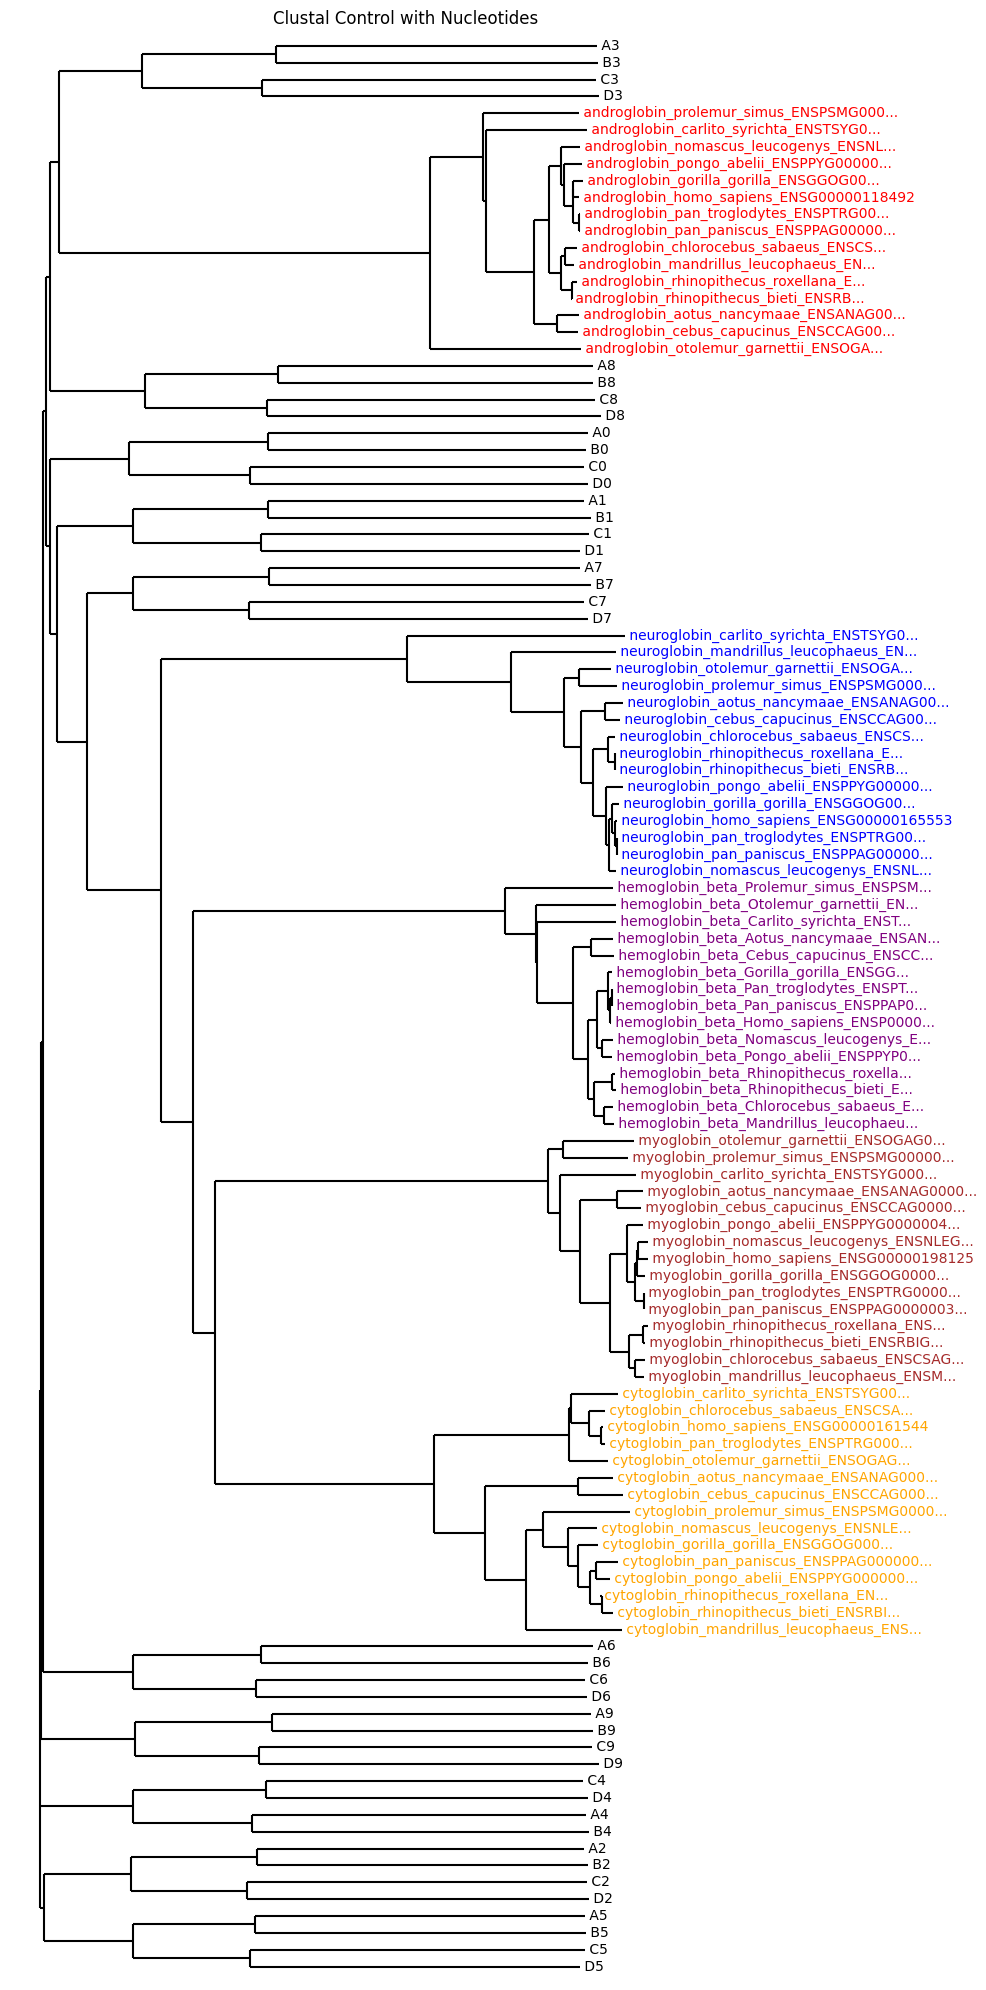

In [14]:
for types in types_map.keys():
    fig, ax = pyplot.subplots(1, 1, figsize=(10, 20), layout="constrained")
    t = Phylo.read(f"{data_path}/blast/{types}/db_blast_phylo.nw", "newick")
    # for a, b in itertools.product("ABCD", "0123456789"):
    #     c = next(t.find_clades(a+b))
    #     c.name = f"indelible_{c.name}"

    # t.ladderize()
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Clustal Control {types_map[types]}")
    ax.axis('off')
    Phylo.draw(
        t,
        show_confidence=False,
        axes=ax,
        do_show=False,
        label_colors=color_clade,
        branch_labels=lambda clade: "" if not clade.name else "{:.2f}".format(
            clade.confidence) if clade.confidence else ""
    )
    pyplot.xlabel("")
    pyplot.ylabel("")
    pyplot.tight_layout()
    pyplot.show()